In [243]:
# this notebook is trying to bring it all together, albeit in a simplified form
# I envision a single lithology
# lateral sediment flux from the sides with L2/T
# channel that adjusts its width in a fixed-width valley
# total Q 
# transport dependent upon valley width

In [244]:
# start with just the math, and steps

## What steps are we following in our model?

### Outside of the loop:
1. Define parameters
- grid spacing $(x)$
- length of domain $(dx)$

- runoff rate $(r)$
- Hack coefficient for basin shape $(k_h)$
- Hack exponent for basin shape $(h)$

- characteristic sediment thickness $(H^*)$

- igneous abrasion coeffcient $(\beta)$
- attrition factor (same as igneous abrasion coeff) $(\psi)$
- erodibility $(K)$

- fraction of "hillslope" / "tributary" material that is coarse $(\gamma)$

- valley width coefficient $(k_{x, B})$
- valley width exponent $(P_{x, B})$
- channel width coefficient $(k_b)$

- porosity $(\phi)$
- grain size $(D)$

- uplift rate $(U)$

2. Set up arrays
- sediment $(H)$
- bedrock $(\eta_b)$
- topography $(\eta)$

3. Calculate constant, derivative values
- total discharge $(Q)$
- valley width $(B)$

### Within the function but before the loop:
1. Define constants (not tunable parameters)
- c
- I
2. Calculate dt
3. Define arrays
- channel width $(b)$
- bedrock erosion $(E_b)$
- sedimentation rate $(E_H)$
- total erosion rate $(E)$
- unit discharge $(q)$
- total sediment transport $(Q_s)$
- unit sediment transport $(q_s)$
- lateral sediment transport $(ql)$
4. Set boundary conditions for $b$, $H$, $E$, $q$, and $q_l$

### Within the loop:
1. Calculate slope using topography $(S)$
- Have started with tiny slope so that we don't get "divide by 0" errors
2. Calculate channel width $(b)$
3. Calculate unit discharge $(q)$
- total discharge divided by channel width
4. Calculate bed cover $(\alpha)$
5. Calculate sediment transport
- total sed transport is W&S Eqn 17 $(Q_s)$
- unit sed transport is total transport divided by valley width $(q_s)$
6. Calculate bedrock erosion via plucking and abrasion
- These processes only occur in the channel (multiply by channel width?)
7. Calculate attrition
- This process happens in the channel, over the unit flux?
8. Calculate lateral sediment inputs
9. Calculate sedimentation rate
- This occurs over the valley width, idea being that over long timescales the entire valley aggrades or incises at roughly the same rate
10. Calculate total erosion rate
- Bedrock erosion minus sedimentation
11. Update topography

In [245]:
import numpy as np
import matplotlib.pyplot as plt

In [246]:
# define parameters

dx = 1 # grid spacing
x = np.arange(0, 101, dx) # domain length
r = 10. # runoff rate
kh = 1/3 # hack coefficient
h = 2 # hack exponent
Hstar = 0.5 # characteristic sediment thickness
beta = 0.00004 # igneous abrasion coefficient
psi = 0.00004 # attrition factor
K = 0.0001 # rock erodibility
gamma = 0.5 # fraction of coarse sediment from hillslope erosion
kxb = 25 # valley width coefficient
Pxb = 1/5 # valley width exponent
kb = 8.3e-8 # channel width coefficient
phi = 0.55 # sediment porosity
D = 0.05 # grain size
U = 0.001

In [247]:
# set up arrays

H = Hstar + np.zeros(len(x)) # sediment thickness
etab = np.zeros(len(x)) # bedrock elevation array
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
eta = etab + H # total topographic elevation

In [248]:
# calculate constant, derivative values

Q = r * kh * (x**h) # total discharge
B = kxb * (x**Pxb) # valley width

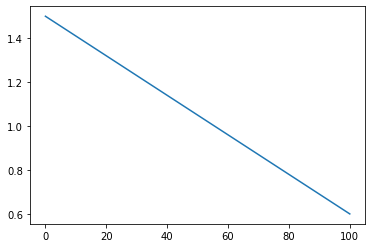

In [249]:
plt.plot(x, eta)

In [250]:
def model(x,
          dx,
          Hstar,
          H,
          etab,
          eta,
          beta,
          psi,
          K,
          gamma,
          kxb,
          Pxb,
          kb,
          phi,
          D,
          U,
          Q,
          B,
          num_steps = 2000000):
    
    # define more constants
    kqs = 0.041 # sediment discharge coefficient
    I = 0.01 # intermittency factor
    
    # calculate timestep
    dt = 0.2 * (0.2 * dx * dx / (kqs*Q[-1]))
    
    # define arrays
    b = np.zeros(len(x)) # channel width
    Eb_p = np.zeros(len(x)) # plucking rate
    Eb_a = np.zeros(len(x)) # abrasion rate
    Eb = np.zeros(len(x)) # bedrock erosion rate
    Eh = np.zeros(len(x)) # sedimentation rate
    E = np.zeros(len(x)) # total erosion rate
    q = np.zeros(len(x)) # unit discharge
    Qs = np.zeros(len(x)) # total sediment transport
    qs = np.zeros(len(x)) # unit sediment transport
    ql = np.zeros(len(x)) # lateral sediment supply
    
    # set boundary conditions
    b[0] = 0
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    qs[0] = 0
    ql[0] = 0
    
    for i in range(num_steps):
        
        # update boundary conditions
        eta[-1] -= U * dt
        etab[-1] = eta[-1]
        
        # calculate slope
        S = np.abs(np.diff(eta)/dx)
        
        # calculate channel width (L)
        # b = (kb * Q[1:] * (S**(7/6))) / (D**(3/2))
        b = (kb * Q[1:] * (S ** (7 / 6))) / (D**(3/2))
        
        # calculate unit discharge (L^2/T)
        q[1:] = Q[1:]/b
        
        # calculate bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calculate sediment transport (L^3/T and L^2/T)
        # Qs[1:] = c * I * Q[1:] * S**(7/6) * (1 - alpha[:-1])
        Qs[1:] = kqs * I * Q[1:] * np.sign(S) * (np.abs(S)) ** (7/6) * (1-alpha[:-1])
        qs[1:] = Qs[1:]/b
        
        # calculate bedrock erosion rates (L^2/T)
        Eb_p[:-1] = K * Q[1:] * S * alpha[:-1]
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        
        # Eb[:-1] = Eb_p[:-1] + Eb_a[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B[1:]
        
        # calculate attrition rate (L^2/T)
        atr = beta * Qs
        
        # calculate lateral sediment inputs (L/T)... needs to be L^2/T
        ql = ((Eb * gamma) / beta) * (1 - np.exp(-beta * (x/3)))
        
        # calculate sedimentation rate (L/T)
        Eh[:-1] = - (1/ (1 - phi) * B[1:]) * ((np.diff(Qs)/dx) + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calculate total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] += Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
    return (S, b, q, Qs, qs, Eb, atr, ql, Eh, E, eta, etab, H, dt)

In [251]:
test_run = [x, dx, Hstar, H, etab, eta, beta, psi, K, gamma, kxb, Pxb, kb, phi, D, U, Q, B]

In [252]:
(S, b, q, Qs, qs, Eb, atr, ql, Eh, E, eta, etab, H, dt) = model(*test_run)

In [253]:
E

array([-8.98540789e-05,  2.74229748e-05,  8.21554146e-05,  1.14842580e-04,
        1.36780715e-04,  1.52594513e-04,  1.64568076e-04,  1.73968835e-04,
        1.81559385e-04,  1.87827027e-04,  1.93098079e-04,  1.97599436e-04,
        2.01493828e-04,  2.04901052e-04,  2.07911287e-04,  2.10593752e-04,
        2.13002496e-04,  2.15180381e-04,  2.17161882e-04,  2.18975087e-04,
        2.20643144e-04,  2.22185300e-04,  2.23617604e-04,  2.24953323e-04,
        2.26203032e-04,  2.27374387e-04,  2.28471556e-04,  2.29494471e-04,
        2.30438205e-04,  2.31292979e-04,  2.32045096e-04,  2.32678597e-04,
        2.33176987e-04,  2.33524481e-04,  2.33706619e-04,  2.33710462e-04,
        2.33524567e-04,  2.33138915e-04,  2.32544832e-04,  2.31734934e-04,
        2.30703075e-04,  2.29444302e-04,  2.27954814e-04,  2.26231906e-04,
        2.24273920e-04,  2.22080173e-04,  2.19650900e-04,  2.16987181e-04,
        2.14090865e-04,  2.10964507e-04,  2.07611291e-04,  2.04034968e-04,
        2.00239788e-04,  

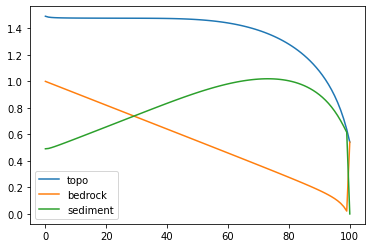

In [254]:
plt.plot(x, eta, label = 'topo')
plt.plot(x, etab, label = 'bedrock')
plt.plot(x, H, label = 'sediment')
plt.legend()

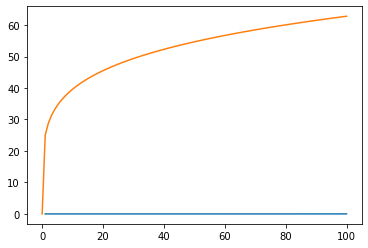

In [266]:
plt.plot(x[1:], b)
plt.plot(x, B)

In [256]:
eta

array([1.49136581, 1.48477594, 1.48217363, 1.48075082, 1.47984771,
       1.47922152, 1.47876085, 1.47840713, 1.47812657, 1.47789826,
       1.47770859, 1.47754829, 1.47741084, 1.47729152, 1.47718683,
       1.47709411, 1.4770113 , 1.4769368 , 1.47686931, 1.47680778,
       1.47675132, 1.4766992 , 1.47665072, 1.47660527, 1.47656218,
       1.47652074, 1.47648011, 1.4764392 , 1.47639666, 1.47635069,
       1.47629904, 1.4762389 , 1.47616692, 1.47607914, 1.47597105,
       1.4758376 , 1.47567317, 1.47547165, 1.47522643, 1.47493043,
       1.47457613, 1.4741556 , 1.47366051, 1.47308215, 1.47241147,
       1.47163911, 1.47075538, 1.4697503 , 1.46861361, 1.46733479,
       1.46590305, 1.46430733, 1.46253629, 1.46057833, 1.45842158,
       1.45605383, 1.45346256, 1.45063492, 1.44755763, 1.44421704,
       1.44059898, 1.43668879, 1.43247121, 1.42793035, 1.42304957,
       1.4178114 , 1.41219747, 1.40618836, 1.39976347, 1.39290089,
       1.38557721, 1.3777673 , 1.36944415, 1.36057853, 1.35113

In [257]:
b

array([7.06087020e-08, 9.55320215e-08, 1.06270974e-07, 1.11169564e-07,
       1.13309194e-07, 1.14049596e-07, 1.14058665e-07, 1.13688547e-07,
       1.13134129e-07, 1.12506875e-07, 1.11871895e-07, 1.11267715e-07,
       1.10717399e-07, 1.10235191e-07, 1.09830865e-07, 1.09513043e-07,
       1.09292392e-07, 1.09185528e-07, 1.09220637e-07, 1.09446229e-07,
       1.09945136e-07, 1.10856970e-07, 1.12413783e-07, 1.14995670e-07,
       1.19215137e-07, 1.26040233e-07, 1.36964804e-07, 1.54227341e-07,
       1.81067484e-07, 2.21996474e-07, 2.83054024e-07, 3.72033392e-07,
       4.98671347e-07, 6.74809232e-07, 9.14532708e-07, 1.23429516e-06,
       1.65302725e-06, 2.19223403e-06, 2.87608095e-06, 3.73147069e-06,
       4.78811307e-06, 6.07859105e-06, 7.63842599e-06, 9.50614582e-06,
       1.17233600e-05, 1.43348450e-05, 1.73886455e-05, 2.09361937e-05,
       2.50324537e-05, 2.97360941e-05, 3.51096939e-05, 4.12199886e-05,
       4.81381601e-05, 5.59401790e-05, 6.47072059e-05, 7.45260588e-05,
      

In [258]:
# see if there's an analytical solution for the bedrock piece

In [259]:
kqs = 0.041
I = 0.01

In [260]:
c1 = kh**(1/2) * r**(1/2) * U * B * K
c2 = (U * kb**(2) * kh**(2) * r**(2) * x**(2*h) * K) / D**(3)
c3 = (beta * kqs * I * kh**(2) * r**(2) * x**(2*h) * kb * K) / D**(3/2)
c4 = beta * kqs * I * kh**(1/2) * r**(1/2) * x**(h/2) * U * B

In [261]:
c4

array([0.00000000e+00, 7.48554162e-10, 1.71972587e-09, 2.79749124e-09,
       3.95089255e-09, 5.16401190e-09, 6.42694717e-09, 7.73287300e-09,
       9.07676755e-09, 1.04547642e-08, 1.18637840e-08, 1.33013111e-08,
       1.47652473e-08, 1.62538127e-08, 1.77654770e-08, 1.92989082e-08,
       2.08529359e-08, 2.24265224e-08, 2.40187408e-08, 2.56287574e-08,
       2.72558182e-08, 2.88992374e-08, 3.05583884e-08, 3.22326960e-08,
       3.39216305e-08, 3.56247020e-08, 3.73414559e-08, 3.90714696e-08,
       4.08143484e-08, 4.25697233e-08, 4.43372482e-08, 4.61165980e-08,
       4.79074664e-08, 4.97095644e-08, 5.15226189e-08, 5.33463712e-08,
       5.51805761e-08, 5.70250006e-08, 5.88794230e-08, 6.07436323e-08,
       6.26174271e-08, 6.45006153e-08, 6.63930130e-08, 6.82944444e-08,
       7.02047409e-08, 7.21237411e-08, 7.40512898e-08, 7.59872380e-08,
       7.79314424e-08, 7.98837650e-08, 8.18440731e-08, 8.38122386e-08,
       8.57881380e-08, 8.77716521e-08, 8.97626656e-08, 9.17610674e-08,
      

In [262]:
soln = c1 * x**(h/2)

In [263]:
soln

array([0.00000000e+00, 4.56435465e-06, 1.04861333e-05, 1.70578734e-05,
       2.40908083e-05, 3.14878775e-05, 3.91887022e-05, 4.71516646e-05,
       5.53461436e-05, 6.37485620e-05, 7.23401461e-05, 8.11055556e-05,
       9.00319956e-05, 9.91086143e-05, 1.08326079e-04, 1.17676269e-04,
       1.27152048e-04, 1.36747088e-04, 1.46455737e-04, 1.56272911e-04,
       1.66194014e-04, 1.76214862e-04, 1.86331637e-04, 1.96540829e-04,
       2.06839210e-04, 2.17223792e-04, 2.27691804e-04, 2.38240668e-04,
       2.48867978e-04, 2.59571483e-04, 2.70349074e-04, 2.81198768e-04,
       2.92118697e-04, 3.03107100e-04, 3.14162310e-04, 3.25282751e-04,
       3.36466927e-04, 3.47713418e-04, 3.59020872e-04, 3.70388002e-04,
       3.81813580e-04, 3.93296435e-04, 4.04835445e-04, 4.16429539e-04,
       4.28077689e-04, 4.39778909e-04, 4.51532255e-04, 4.63336817e-04,
       4.75191722e-04, 4.87096128e-04, 4.99049226e-04, 5.11050235e-04,
       5.23098402e-04, 5.35193000e-04, 5.47333327e-04, 5.59518704e-04,
      

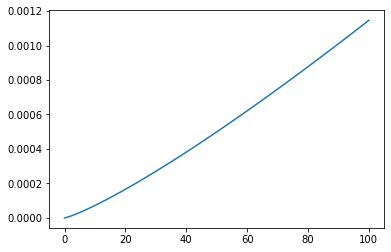

In [264]:
plt.plot(x, soln)

In [265]:
new_c = c2 - c3